In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/Users/elenag/Desktop/PlotterLEE/PELEE/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 04282020


In [4]:
SHRCALIBFACTOR = 1.00

In [5]:
# Doing Run3?
ISRUN3 = False

In [6]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [8]:
tree = "NeutrinoSelectionFilter"

BNB = 'neutrinoselection_filt_run1_NuMI_beamon'+ls.APPEND
EXT = 'neutrinoselection_filt_run1_NuMI_ext'+ls.APPEND
NU  = 'neutrinoselection_filt_run1_NuMI_overlay'+ls.APPEND
NUE = 'neutrinoselection_filt_run1_NuMI_overlay'+ls.APPEND



data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]

uproot_v = [nue,ext,data,mc]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category",
    "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
    "topological_score",
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_calo_energy_y_v", # track calo energy
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
    "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
    "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
    "pfnhits","pfnunhits"
]
#make the list unique
variables = list(set(variables))
print(variables)

#if not ISRUN3:
variables.remove("_closestNuCosmicDist")
variables.remove("crtveto")
variables.remove("crthitpe")
    
WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune"]#, "weightsGenie", "weightsFlux", "weightsReint"]
WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]
SYSTEMATICS = []# ['weightsFlux','weightsGenie']


mc   = mc   .pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS, flatten=False)
nue  = nue  .pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext .pandas.df(variables, flatten=False)


['category', 'nslice', 'NeutrinoEnergy2', 'evt', 'shr_energy_tot_cali', 'backtracked_pdg', 'slnhits', 'p', 'pfnunhits', 'shrclusdir2', 'shr_tkfit_2cm_dedx_Y', 'shr_tkfit_2cm_nhits_U', 'shr_tkfit_2cm_dedx_V', 'shr_tkfit_gap10_nhits_U', 'selected', 'run', 'shr_score', 'best_cosmic_flashmatch_score', 'shr_tkfit_2cm_nhits_Y', 'shr_tkfit_gap10_dedx_U', 'hits_y', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'shr_energy', 'nu_flashmatch_score', 'shr_tkfit_nhits_V', 'tksh_angle', 'trk_llr_pid_score_v', 'shr_dedx_Y', '_opfilter_pe_beam', 'shr_tkfit_nhits_Y', 'shr_pfp_id_v', 'trk_calo_energy_y_v', 'ccnc', 'trk_score_v', 'reco_nu_vtx_y', 'nu_pdg', 'slnunhits', 'shr_tkfit_gap10_nhits_V', 'trk_energy_tot', 'pi0_e', 'sub', 'trk_len', 'trk_theta', 'n_tracks_contained', 'reco_nu_vtx_z', 'CosmicIP', 'CosmicIPAll3D', 'shrmoliereavg', 'shr_tkfit_dedx_V', 'CosmicDirAll3D', '_closestNuCosmicDist', 'mc_pdg', 'shr_dedx_U', 'shr_dedx_Y_cali', 'matched_E', 'shrmoliererms', 'secondshower_Y_nhit', 'npion', 'nproton

In [9]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
import time
s = time.time()
df_v = [nue,ext,data,mc]
puppa1 = 'trk_score_v'
#print ('trk_llr_pid_score_v' in nue.columns.to_list())
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    
    print(trk_score_v.shape, len(trk_llr_pid_v))
#    print(len(c), len(trk_id), len(trk_llr_pid_v))
#    for pidv,puppa,tid,cid in zip(trk_llr_pid_v,trk_score_puppa_v,trk_id,c):
#        if len(pidv) > 0:
#            print(len(pidv),len(puppa), pidv,puppa,tid,cid )
#    nnnnnnnPupppppppaaa = 0
#    print(type(trk_llr_pid_v), trk_llr_pid_v.shape)
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])

    #df['n_proton_cand']   = puppa_proton
    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos']     = np.cos(df['trk_theta'])
    #print(  df['N_recoShowers'])
    
s2 = time.time()
print (s-s2)

(49672,) 49672
(285851,) 285851
(122491,) 122491
(49672,) 49672
-10.125930070877075


In [10]:
#
for i,df in enumerate(df_v):
    up = uproot_v[i]
    df["slclnhits"] = up.array("pfnhits").sum()
    df["slclnunhits"] = up.array("pfnunhits").sum()
#

In [11]:
df_v = [nue,ext,data,mc]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot']       = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_dedx_avg']        = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot']   = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg']    = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg']  = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max']  = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U'] > df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V'] > df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [12]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['protonenergy'] = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos'] = np.cos(df['trk_theta'])
    #df['FMdiffOBV'] = df['nu_flashmatch_score']-df['best_obviouscosmic_flashmatch_score']
    #df['FMdiff'] = df['nu_flashmatch_score']-df['best_cosmic_flashmatch_score']

In [13]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])


In [14]:
# add back the cosmic category, for background only
df_v = [nue,ext,data,mc]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [15]:
data["is_signal"] = data["category"] == 11
nue  ["is_signal"] = nue  ["category"] == 11
mc  ["is_signal"] = mc  ["category"] == 11
ext ["is_signal"] = ext ["category"] == 11


In [16]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/Users/elenag/Desktop/PlotterLEE/PELEE/plotter.py'>

In [27]:
nue = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc"  : mc,
    "nue" : nue,
    "data": data,
    "ext" : ext,}

scaling = 1
SPLIT   = 1.0 #0. trying to remove the MC 
weights = {
    "mc"  : 1. * scaling,
    "nue" : 1. * scaling,
    "ext" : 1. * scaling, #C+D+E #C only: 1.40e-01
    }
pot = 4.0e19*scaling
    
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 1.0, 'nue': 1.0, 'ext': 1.0}


Missing dirt sample


In [ ]:
# muon selection
QUERY = 'nslice == 1'
QUERY += ' and n_tracks_contained >= 1 and N_recoProtons >= 1'
QUERY += ' and selected == 1'
QUERY += ' and shr_energy_tot_cali > 0.07'
QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

print (QUERY)

In [28]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'
NPVLCUTQ += ' and reco_e > 1.05'
QUERY = NPVLCUTQ
print (QUERY)

nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.25 and hits_ratio > 0.5 and trkfit < 0.90 and tksh_distance < 10.0 and tksh_angle > -0.9 and reco_e > 1.05


invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in double_scalars
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in double_scalars


Profile likelihood: 0.00 sigma @ 1.01e21 POT
s/sqrt(b): 0.00 sigma @ 1.01e21 POT


(0.7, 1.1)

invalid value encountered in double_scalars


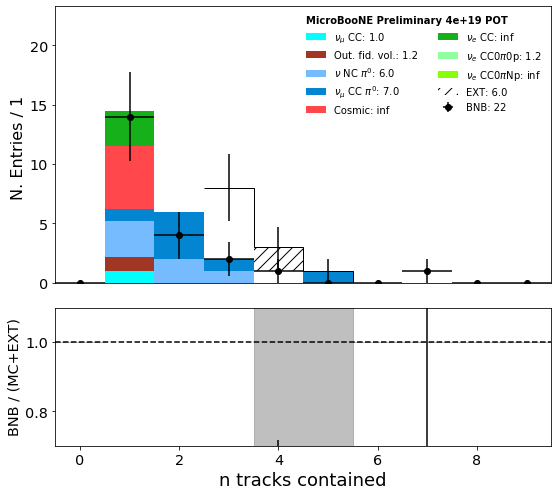

In [19]:
#QUERY = PRESQ
VARIABLE, BINS, RANGE, XTIT = 'n_tracks_contained',10,(-0.5,9.5),"n tracks contained"
#VARIABLE, BINS, RANGE, XTIT = 'trkpid',50,(-2.5,2.5),"Number of Tracks"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,
    kind="event_category",
    #kind="interaction",
    #kind="sample",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE
)[0:3]

print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,200)
ax1.set_ylim(0,ax1.get_ylim()[1]*1.25)
ax2.set_ylim(0.7,1.1)
#fig.savefig(ls.plots_path+"run1/presel/"+VARIABLE+"_"+date_time+".pdf")

In [ ]:
#data.query(QUERY)[["run","sub","evt","reco_e"]]
f = data.query(QUERY)[["run","sub"]]#.to_string(index=False)
query4SamWeb = f.apply(lambda x: str(x['run'])+'.'+str(x['sub'])+',', axis=1).sum()
print("defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_v0 and run_number "+query4SamWeb)



In [ ]:
#data.query(QUERY)[["run","sub","evt","reco_e"]]
f = data.query(QUERY)[["run","sub","evt"]]
np.savetxt(r'NNfileListNue.txt', f.values, fmt='%d')


In [ ]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'


In [ ]:
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

In [26]:
quickQUERY = 'true_e_visible > 1.0 and (abs(nu_pdg) == 12)'
s = mc.query(quickQUERY)[["run","sub","evt","true_e_visible","nu_pdg"]]
print(s)

        run   sub    evt  true_e_visible  nu_pdg
entry                                           
1      7012   603  30152        2.901257     -12
3      7012   603  30154        1.091179      12
18     7012   603  30169        1.055034      12
48     7012   603  30199        1.072797      12
59     6379    94   4717        1.988270      12
...     ...   ...    ...             ...     ...
49458  7012  1520  76035        1.466988     -12
49478  7006   211  10555        2.694846     -12
49528  7004   407  20355        1.022946      12
49553  7004   407  20381        1.551356      12
49607  7004  1106  55335        1.286950      12

[1044 rows x 5 columns]


In [ ]:
# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and n_showers_contained == 1'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'

In [ ]:
# loose box cuts
NPLCUTQ = NPPRESQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.02'
NPLCUTQ += ' and hits_ratio > 0.50'
NPLCUTQ += ' and shrmoliereavg < 9'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.65'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'

In [ ]:
# tight box cuts
NPTCUTQ = NPLCUTQ
NPTCUTQ += ' and CosmicIPAll3D > 30.'
NPTCUTQ += ' and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98'
NPTCUTQ += ' and trkpid < 0.02'
NPTCUTQ += ' and hits_ratio > 0.65'
NPTCUTQ += ' and shr_score < 0.25'
NPTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 10'
NPTCUTQ += ' and subcluster > 7'
NPTCUTQ += ' and trkfit < 0.70'
NPTCUTQ += ' and n_showers_contained == 1'
NPTCUTQ += ' and tksh_distance < 4.0'
NPTCUTQ += ' and trkshrhitdist2 < 1.5'
NPTCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8)'
NPTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
NPTCUTQ += ' and secondshower_Y_nhit < 30'
NPTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.70'

In [ ]:
# OLD loose box cuts
OLCUTQ = PRESQ
OLCUTQ += ' and CosmicIP > 20.'
OLCUTQ += ' and trkpid < 0.1'
OLCUTQ += ' and hits_ratio > 0.5'
OLCUTQ += ' and shr_score < 0.30'
OLCUTQ += ' and n_showers_contained == 1'
OLCUTQ += ' and tksh_distance < 6.0'
OLCUTQ += ' and shr_tkfit_2cm_dedx_avg < 4.0'
OLCUTQ += ' and tksh_angle > -0.9'
# OLD tight box cuts
OTCUTQ = OLCUTQ
OTCUTQ += ' and tksh_distance < 3.5'
OTCUTQ += ' and (shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)'
OTCUTQ += ' and (shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)'
OTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.75'
OTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 9'
OTCUTQ += ' and trkpid < -0.02'
OTCUTQ += ' and n_showers_contained == 1'
OTCUTQ += ' and shr_score < 0.275'
OTCUTQ += ' and hits_ratio > 0.60'
OTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
OTCUTQ += ' and (trkfit < 0.45 or subcluster > 6)'

In [ ]:
# BDT cuts
# 0304 extnumi, pi0 and nonpi0
BDTCQ = NPLCUTQ
BDTCQ += ' and pi0_score > 0.67 and nonpi0_score > 0.70'

In [ ]:
# Define actual selection
QUERY = PRESQ
# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'
# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [ ]:
v = "$\cos\left(\theta_{\mu}\right)$"

#QUERY += " & pi0truth_elec_etot<15 & npi0 == 0 & ccnc == 0"
#QUERY += " & muon_e>0.3 & npi0 == 0 & ccnc == 0"
#QUERY = "(muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category == 2"
#QUERY += " & ~((muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category != 5)"


VARIABLE, BINS, RANGE, XTIT = 'trkpid',14,(0.15,1.55),r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'reco',25,(0,1),r"topological score"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_mass_Y',20,(0,500),"pi0 mass Y"

#VARIABLE, BINS, RANGE, XTIT = 'muon_e',20,(0.,1.),r"Muon Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0truth_elec_etot',20,(0.,60),r"Michel Energy [GeV]"

#fig, ax1, ax2 = my_plotter.plot_variable(
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,#+" and category != 111",
    kind="event_category",
    #kind="sample",
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,240)
ax1.set_ylim(0,ax1.get_ylim()[1]*1.25)
#ax2.set_ylim(0.5,1.5)
#fig.savefig(ls.plots_path+VARIABLE+"_"+date_time+".pdf")

In [ ]:
#cccpi.query(QUERY)[["run","sub","evt","reco_e"]]
data.query(QUERY)[["run","sub","evt","reco_e"]]